In [1]:
import requests
import zipfile
import io
import os
import pandas as pd
import statsmodels.formula.api as smf
from robustipy.models import OLSRobust

Download the maketable2.zip from Dropbox:

In [2]:
url = "https://www.dropbox.com/s/1s1yb7a3hkjwzjh/maketable2.zip?dl=1"
response = requests.get(url)
response.raise_for_status()

Unzip into a local 'data' directory:

In [3]:
os.makedirs('../data/acemoglu_example', exist_ok=True)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall('../data/acemoglu_example')

Load the Stata file:

In [4]:
df = pd.read_stata('../data/acemoglu_example/maketable2.dta')

Define a helper to run and display OLS with robust SEs:

In [5]:
def run_regression(formula, data, label):
    model = smf.ols(formula, data=data).fit(cov_type='HC1')
    print(f"\n--- Column {label} ---")
    print(model.summary())

Execute each column's regression:

In [6]:
run_regression('logpgp95 ~ avexpr', df, 1)
run_regression('logpgp95 ~ avexpr', df[df['baseco'] == 1], 2)
run_regression('logpgp95 ~ avexpr + lat_abst', df, 3)
run_regression('logpgp95 ~ avexpr + lat_abst + africa + asia + other', df, 4)
run_regression('logpgp95 ~ avexpr + lat_abst', df[df['baseco'] == 1], 5)
run_regression('logpgp95 ~ avexpr + lat_abst + africa + asia + other', df[df['baseco'] == 1], 6)
run_regression('loghjypl ~ avexpr', df, 7)
run_regression('loghjypl ~ avexpr', df[df['baseco'] == 1], 8)


--- Column 1 ---
                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     334.8
Date:                Tue, 06 May 2025   Prob (F-statistic):           5.14e-35
Time:                        10:34:43   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6261      0.241  

Now do RobustiPy things:

In [7]:
acemoglu_robust = OLSRobust(y=['logpgp95'], x=['avexpr'], data=df)
acemoglu_robust.fit(controls=['lat_abst', 'africa', 'asia', 'other'],
                    draws=1000,
                    kfold=10,
                    seed=192735,
                    oos_metric='rmse',
                    threshold=1000000)

Output()

[OLSRobust] Running with n_cpu=31, draws=1000


/home/jinx/anaconda3/lib/python3.12/site-packages/robustipy/prototypes.py:128: MissingValueWarning: Missing values found in data. Listwise deletion will be applied.
  warnings.warn(


Get the results:

In [8]:
df_results = acemoglu_robust.get_results()

Plot:

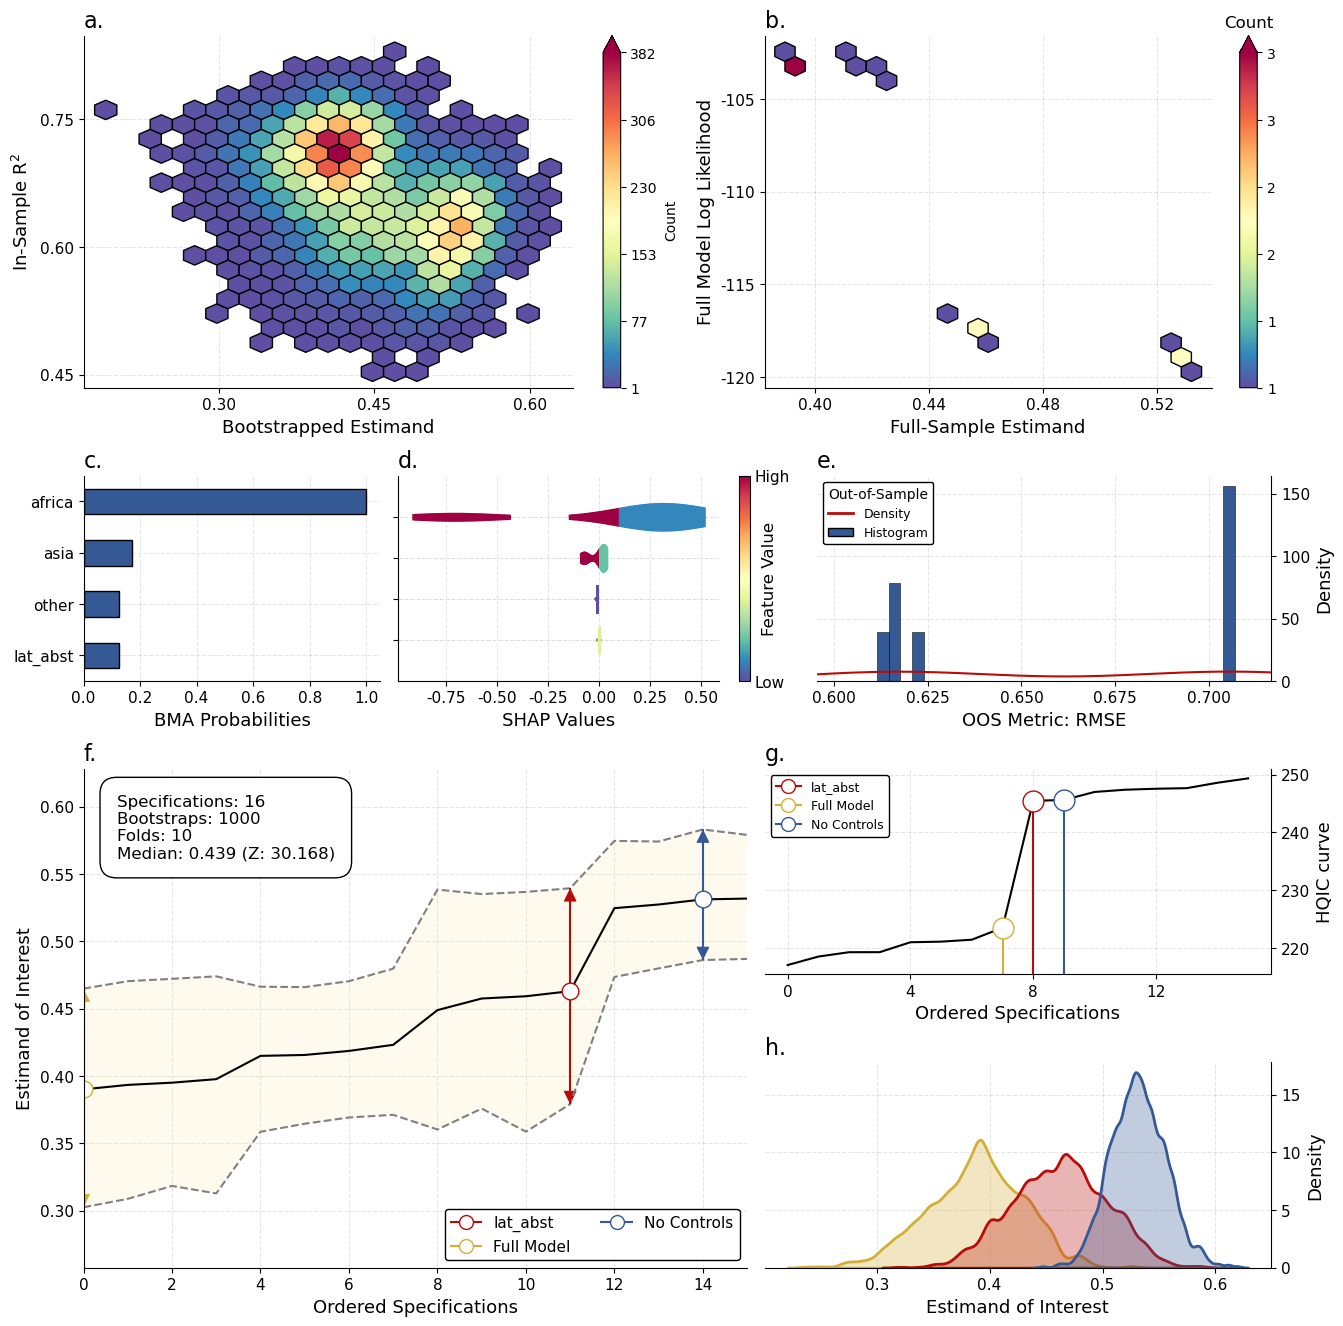

In [9]:
df_results.plot(specs=[['lat_abst']],
                ic='hqic',
                ext='pdf',
                ci=0.95,
                loess=False,
                project_name='acemoglu_example',
                figsize=(16, 16)
                )

Summarize results:

In [10]:
df_results.summary()

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: logpgp95
Independent variable: avexpr
Number of possible controls: 4
Number of draws: 1000
Number of folds: 10
Number of specifications: 16
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): 0.437 (p-value: 0.0)
Median beta (all bootstraps and specifications): 0.439
Min beta (all specifications, no resampling): 0.39
Min beta (all bootstraps and specifications): 0.191
Max beta (all specifications, no resampling): 0.532
Max beta (all bootstraps and specifications): 0.62
AIC-weighted beta (all specifications, no resampling): 0.402
BIC-weighted beta (all specifications, no resampling): 0.419
HQIC-weighted beta (all specifications, no resampling): 0.414
Significant portion of beta (all specifications, no resampling): 1.0 (p-value: 0.0)
Significant portion of beta (all bootstraps and specifications): 1.0
Positive portion of beta (all specifications, no resampling): 1.0 (